# Regression Deep Learning Model for Allstate Claims Severity Using TensorFlow Take 4
### David Lowe
### February 20, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Allstate Claims Severity dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: Allstate is interested in developing automated methods of predicting the cost, and hence severity, of claims. In this Kaggle challenge, the contestants were asked to create an algorithm which could accurately predicts claims severity. Each row in this dataset represents an insurance claim. The task is to predict the value for the 'loss' column. Variables prefaced with 'cat' are categorical, while those prefaced with 'cont' are continuous.

In iteration Take1, we constructed machine learning models using the original dataset and with minimum data preparation and no feature engineering. The XGBoost model serves as the baseline for the future iterations of modeling.

In iteration Take2, we tuned additional parameters of the XGBoost model and improved the MAE metric further.

In iteration Take3, we constructed several basic Multilayer Perceptron (MLP) models with one hidden layer. The basic MLP model serves as the baseline model as we build more complex MLP models in future iterations.

In this iteration, we will construct several Multilayer Perceptron (MLP) models with two hidden layers. We will observe whether the additional hidden layer has a positive effect on MAE when compared to models that have just one hidden layer.

ANALYSIS: In iteration Take1, the baseline performance of the machine learning algorithms achieved an average MAE of 1301. eXtreme Gradient Boosting (XGBoost) achieved the top MAE metric after the first round of modeling. After a series of tuning trials, XGBoost achieved an MAE metric of 1199. By using the optimized parameters, the XGBoost algorithm processed the test dataset with an MAE of 1204, which was in line with the MAE prediction from the training data.

In iteration Take2, the further-tuned eXtreme Gradient Boosting (XGBoost) model achieved an improved MAE metric of 1191 using the training data. By using the same optimized parameters, the XGBoost algorithm processed the test dataset with an MAE of 1195, which was in line with the MAE prediction from the training data.

In iteration Take3, the simple MLP model with 128 nodes achieved an MAE metric of 1193 on the test dataset after 50 epochs. The MLP model with 1024 nodes processed the same test dataset with an MAE of 1170 after the same number of epochs but with a much larger over-fitting.

In this iteration Take4, the MLP model with 128/64 nodes and 0.25/0.25 Dropout ratios achieved an MAE metric of 1169 on the test dataset after 31 epochs. The MLP model with 256/128 nodes and 0.25/0.50 Dropout ratios also processed the same test dataset with an MAE of 1169 after 25 epochs.

CONCLUSION: For this iteration, the 128/64-node with 0.25/0.25 Dropout MLP model achieved good overall results using the training and testing datasets. It is a model that is simpler than the model that has 256/128 nodes and 0.25/0.50 Dropout. For this dataset, we should consider experimenting with more and complex MLP models.

Dataset Used: Allstate Claims Severity Data Set

Dataset ML Model: Regression with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/allstate-claims-severity/data

One potential source of performance benchmarks: https://www.kaggle.com/c/allstate-claims-severity/leaderboard

Any deep-learning modeling project genrally can be broken down into about seven major tasks:

0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [0]:
# Retrieve GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Feb 13 22:04:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
# Set the random seed number for reproducible results
seedNum = 888

In [0]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

In [0]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
# verbose = True
# tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_loss = 'mae'
default_optimizer = tf.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.initializers.RandomNormal(seed=seedNum)
default_epoch = 50
default_batch = 64

Num GPUs Available:  1


In [0]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Regression Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [0]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [0]:
if (notifyStatus): email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [0]:
if (notifyStatus): email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [0]:
dataset_path = 'https://dainesanalytics.com/datasets/py-classification-allstate-claims-severity/train.csv'
Xy_original = pd.read_csv(dataset_path)

# Take a peek at the dataframe after the import
Xy_original.head(10)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,...,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,...,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85
5,13,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,D,E,C,A,P,J,D,A,A,E,E,H,F,B,BI,CS,A,AS,AE,A,K,DJ,0.546670,0.681761,0.634224,0.373816,0.302678,0.364464,0.401162,0.26847,0.46226,0.50556,0.366788,0.359249,0.345247,0.726792,5142.87
6,14,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,...,A,D,D,D,E,C,A,P,J,A,A,C,E,E,H,F,B,BI,DK,A,J,AF,A,K,DJ,0.471447,0.737068,0.613660,0.189137,0.295397,0.381515,0.363768,0.24564,0.40455,0.47225,0.334828,0.352251,0.342239,0.382931,1132.22
7,20,A,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,B,A,A,A,B,A,A,A,A,A,A,A,...,A,C,B,C,E,A,C,T,H,C,A,A,K,F,F,I,G,BI,EB,G,AH,Y,A,P,LO,0.826591,0.488789,0.263570,0.623770,0.473767,0.867021,0.583389,0.90267,0.84847,0.80218,0.644013,0.785706,0.859764,0.242416,3585.75
8,23,A,B,B,B,B,A,A,A,B,B,B,B,B,A,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,...,A,D,C,C,E,C,D,T,C,Q,A,C,H,F,G,M,K,BI,BC,C,K,AX,A,Q,IE,0.330514,0.555782,0.440642,0.473202,0.281143,0.628534,0.384099,0.61229,0.38249,0.51111,0.682315,0.669033,0.756454,0.361191,10280.20
9,24,A,B,A,A,B,B,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,B,...,H,D,B,C,E,A,C,T,F,D,A,F,K,H,G,J,G,BU,DW,A,U,S,J,O,LY,0.726300,0.358319,0.356819,0.802892,0.310061,0.713343,0.469223,0.30260,0.67135,0.83510,0.863052,0.879347,0.822493,0.294523,6184.59


In [0]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [0]:
Xy_original.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


In [0]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

id        0
cat1      0
cat2      0
cat3      0
cat4      0
         ..
cont11    0
cont12    0
cont13    0
cont14    0
loss      0
Length: 132, dtype: int64
Total number of NaN in the dataframe:  0


## 1.b) Data Cleaning

In [0]:
# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'loss': 'targetVar'})

# Dropping unnecessary feature(s)
Xy_original.drop(columns=['id'], inplace=True)

# Convert columns from one data type to another
categorical_cols = ["cat" + str(i) for i in range(1,117)]
Xy_original[categorical_cols] = Xy_original[categorical_cols].astype('category')

# Take a peek at the dataframe after the cleaning
Xy_original.head(10)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,...,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,targetVar
0,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,...,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85
5,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,D,E,C,A,P,J,D,A,A,E,E,H,F,B,BI,CS,A,AS,AE,A,K,DJ,0.546670,0.681761,0.634224,0.373816,0.302678,0.364464,0.401162,0.26847,0.46226,0.50556,0.366788,0.359249,0.345247,0.726792,5142.87
6,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,...,A,D,D,D,E,C,A,P,J,A,A,C,E,E,H,F,B,BI,DK,A,J,AF,A,K,DJ,0.471447,0.737068,0.613660,0.189137,0.295397,0.381515,0.363768,0.24564,0.40455,0.47225,0.334828,0.352251,0.342239,0.382931,1132.22
7,A,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,B,A,A,A,B,A,A,A,A,A,A,A,A,...,A,C,B,C,E,A,C,T,H,C,A,A,K,F,F,I,G,BI,EB,G,AH,Y,A,P,LO,0.826591,0.488789,0.263570,0.623770,0.473767,0.867021,0.583389,0.90267,0.84847,0.80218,0.644013,0.785706,0.859764,0.242416,3585.75
8,A,B,B,B,B,A,A,A,B,B,B,B,B,A,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,A,...,A,D,C,C,E,C,D,T,C,Q,A,C,H,F,G,M,K,BI,BC,C,K,AX,A,Q,IE,0.330514,0.555782,0.440642,0.473202,0.281143,0.628534,0.384099,0.61229,0.38249,0.51111,0.682315,0.669033,0.756454,0.361191,10280.20
9,A,B,A,A,B,B,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,B,B,...,H,D,B,C,E,A,C,T,F,D,A,F,K,H,G,J,G,BU,DW,A,U,S,J,O,LY,0.726300,0.358319,0.356819,0.802892,0.310061,0.713343,0.469223,0.30260,0.67135,0.83510,0.863052,0.879347,0.822493,0.294523,6184.59


In [0]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 131 entries, cat1 to targetVar
dtypes: category(116), float64(15)
memory usage: 42.8 MB


In [0]:
Xy_original.describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,targetVar
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


In [0]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

cat1         0
cat2         0
cat3         0
cat4         0
cat5         0
            ..
cont11       0
cont12       0
cont13       0
cont14       0
targetVar    0
Length: 131, dtype: int64
Total number of NaN in the dataframe:  0


## 1.c) Feature Scaling and Pre-processing

In [0]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [0]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (188318, 131) X_original.shape: (188318, 130) y_original.shape: (188318,)


## 1.d) Splitting Data into Training and Test Sets

In [0]:
# Perform one-hot-encoding before splitting into trainig and test
X_original = pd.get_dummies(X_original)
print(X_original.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 1153 entries, cont1 to cat116_Y
dtypes: float64(14), uint8(1139)
memory usage: 224.7 MB
None


In [0]:
X_encoded = X_original.to_numpy()
y_encoded = y_original.to_numpy()
if (splitDataset):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, random_state=seedNum)
else:
    X_train, y_train = X_encoded, y_encoded
    X_test, y_test = X_encoded, y_encoded
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.type: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.type: {}".format(y_test.shape, type(y_test)))

X_train.shape: (141238, 1153) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (141238,) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (47080, 1153) X_test.type: <class 'numpy.ndarray'>
y_test.shape: (47080,) y_test.type: <class 'numpy.ndarray'>


In [0]:
if (notifyStatus): email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Baseline Model Architecture

In [0]:
if (notifyStatus): email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Define MLP model #1_a
def create_model_1_a():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #1_b
def create_model_1_b():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #1_c
def create_model_1_c():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #1_c
def create_model_1_d():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
if (notifyStatus): email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model Set #1

In [0]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 10s 74us/sample - loss: 1423.1601 - val_loss: 1230.2590
Epoch 2/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1206.1840 - val_loss: 1213.1045
Epoch 3/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1192.6605 - val_loss: 1205.6185
Epoch 4/50
141238/141238 [==============================] - 10s 73us/sample - loss: 1185.7636 - val_loss: 1201.2046
Epoch 5/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1181.2102 - val_loss: 1197.1102
Epoch 6/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1176.8240 - val_loss: 1199.5425
Epoch 7/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1173.5027 - val_loss: 1202.3225
Epoch 8/50
141238/141238 [==============================] - 10s 72us/sample - loss: 1169.7819 - val_loss: 1190.7853
Epoch 9/50
141238/141

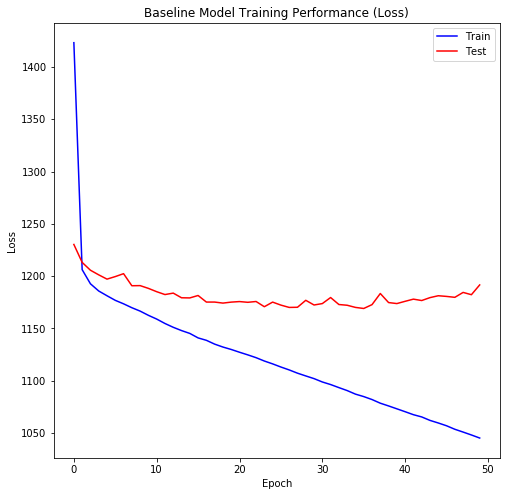

In [0]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_1_a = create_model_1_a()
baseline_hist_1_a = baseline_model_1_a.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist_1_a.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_1_a.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 11s 76us/sample - loss: 1346.2367 - val_loss: 1231.8614
Epoch 2/50
141238/141238 [==============================] - 10s 73us/sample - loss: 1238.8944 - val_loss: 1217.6179
Epoch 3/50
141238/141238 [==============================] - 10s 74us/sample - loss: 1229.0953 - val_loss: 1207.8199
Epoch 4/50
141238/141238 [==============================] - 10s 73us/sample - loss: 1223.5840 - val_loss: 1202.2910
Epoch 5/50
141238/141238 [==============================] - 11s 75us/sample - loss: 1215.8061 - val_loss: 1199.6884
Epoch 6/50
141238/141238 [==============================] - 10s 74us/sample - loss: 1214.2386 - val_loss: 1201.5637
Epoch 7/50
141238/141238 [==============================] - 10s 74us/sample - loss: 1208.8904 - val_loss: 1193.3836
Epoch 8/50
141238/141238 [==============================] - 10s 73us/sample - loss: 1205.8572 - val_loss: 1192.6362
Epoch 9/50
141238/141

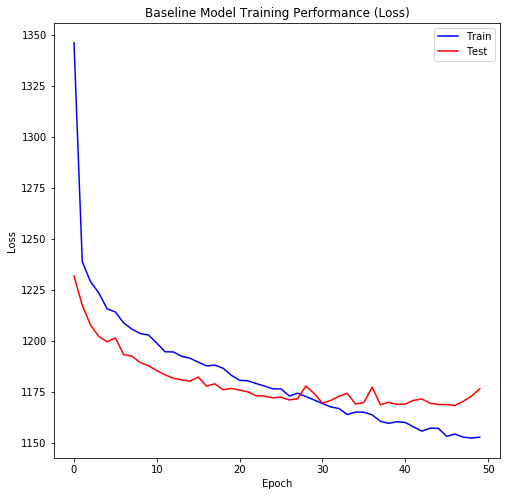

In [0]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_1_b = create_model_1_b()
baseline_hist_1_b = baseline_model_1_b.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist_1_b.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_1_b.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 10s 73us/sample - loss: 1384.5913 - val_loss: 1235.2302
Epoch 2/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1278.6936 - val_loss: 1218.3276
Epoch 3/50
141238/141238 [==============================] - 10s 72us/sample - loss: 1269.9510 - val_loss: 1208.8652
Epoch 4/50
141238/141238 [==============================] - 10s 73us/sample - loss: 1264.6780 - val_loss: 1204.6205
Epoch 5/50
141238/141238 [==============================] - 10s 72us/sample - loss: 1259.0351 - val_loss: 1202.3557
Epoch 6/50
141238/141238 [==============================] - 10s 73us/sample - loss: 1257.1318 - val_loss: 1217.6825
Epoch 7/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1252.9803 - val_loss: 1202.2132
Epoch 8/50
141238/141238 [==============================] - 10s 73us/sample - loss: 1251.0656 - val_loss: 1210.0944
Epoch 9/50
141238/141

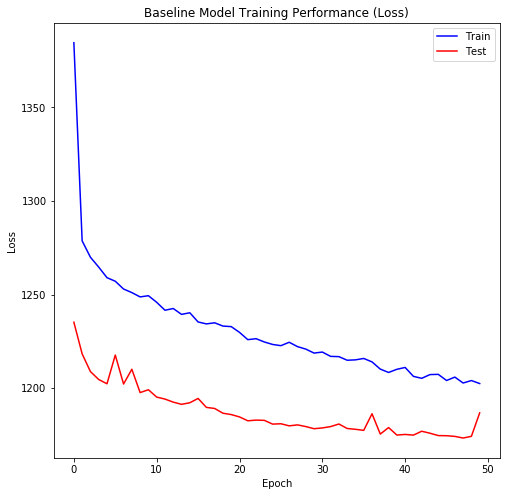

In [0]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_1_c = create_model_1_c()
baseline_hist_1_c = baseline_model_1_c.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist_1_c.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_1_c.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 11s 75us/sample - loss: 1413.8089 - val_loss: 1239.4934
Epoch 2/50
141238/141238 [==============================] - 10s 69us/sample - loss: 1296.1366 - val_loss: 1224.4328
Epoch 3/50
141238/141238 [==============================] - 10s 72us/sample - loss: 1289.8810 - val_loss: 1214.8461
Epoch 4/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1282.0047 - val_loss: 1209.6278
Epoch 5/50
141238/141238 [==============================] - 10s 73us/sample - loss: 1276.4843 - val_loss: 1206.3264
Epoch 6/50
141238/141238 [==============================] - 10s 72us/sample - loss: 1275.8611 - val_loss: 1216.6473
Epoch 7/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1270.6051 - val_loss: 1204.2941
Epoch 8/50
141238/141238 [==============================] - 10s 72us/sample - loss: 1268.0509 - val_loss: 1211.9773
Epoch 9/50
141238/141

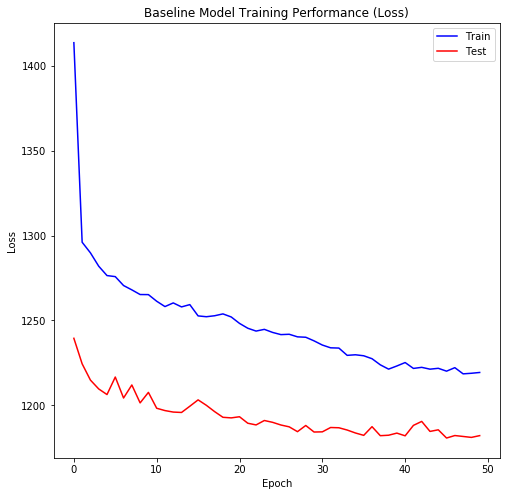

In [0]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_1_d = create_model_1_d()
baseline_hist_1_d = baseline_model_1_d.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist_1_d.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_1_d.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Fit and Evaluate Model Set #2

In [0]:
if (notifyStatus): email_notify("Phase 4 Fit and Evaluate Model Set #2 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Define MLP model #2_a
def create_model_2_a():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #2_b
def create_model_2_b():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #2_c
def create_model_2_c():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #2_d
def create_model_2_d():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 10s 72us/sample - loss: 1269.3556 - val_loss: 1216.5828
Epoch 2/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1192.9644 - val_loss: 1201.7355
Epoch 3/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1181.7752 - val_loss: 1194.9207
Epoch 4/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1173.6646 - val_loss: 1188.7287
Epoch 5/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1166.8456 - val_loss: 1183.5393
Epoch 6/50
141238/141238 [==============================] - 10s 69us/sample - loss: 1159.7460 - val_loss: 1181.8811
Epoch 7/50
141238/141238 [==============================] - 10s 69us/sample - loss: 1153.7145 - val_loss: 1181.3602
Epoch 8/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1148.5571 - val_loss: 1173.6297
Epoch 9/50
141238/141

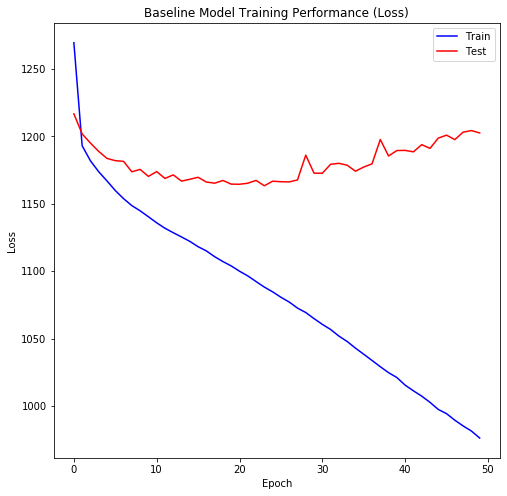

In [0]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_2_a = create_model_2_a()
baseline_hist_2_a = baseline_model_2_a.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist_2_a.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_2_a.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 10s 74us/sample - loss: 1290.7344 - val_loss: 1218.1566
Epoch 2/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1213.5454 - val_loss: 1206.7900
Epoch 3/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1206.5673 - val_loss: 1200.9958
Epoch 4/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1198.8979 - val_loss: 1199.2230
Epoch 5/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1197.3021 - val_loss: 1194.7853
Epoch 6/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1191.2692 - val_loss: 1193.3259
Epoch 7/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1188.3884 - val_loss: 1194.2598
Epoch 8/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1184.5708 - val_loss: 1191.3511
Epoch 9/50
141238/141

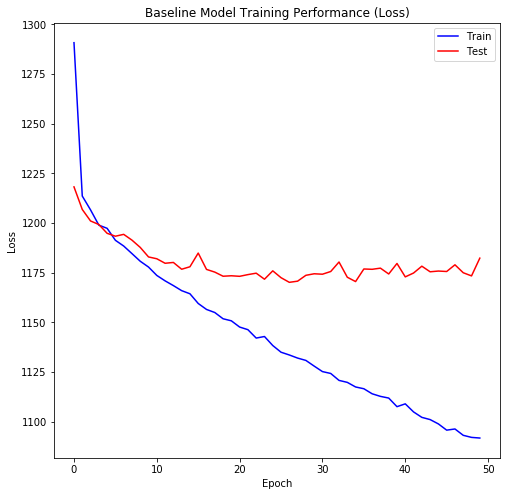

In [0]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_2_b = create_model_2_b()
baseline_hist_2_b = baseline_model_2_b.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist_2_b.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_2_b.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 10s 73us/sample - loss: 1313.7076 - val_loss: 1218.1115
Epoch 2/50
141238/141238 [==============================] - 10s 69us/sample - loss: 1235.1523 - val_loss: 1205.9492
Epoch 3/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1228.3103 - val_loss: 1199.7620
Epoch 4/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1219.2574 - val_loss: 1199.2244
Epoch 5/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1217.8508 - val_loss: 1191.0256
Epoch 6/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1211.3848 - val_loss: 1191.9842
Epoch 7/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1208.8402 - val_loss: 1189.3453
Epoch 8/50
141238/141238 [==============================] - 10s 72us/sample - loss: 1204.4179 - val_loss: 1188.2310
Epoch 9/50
141238/141

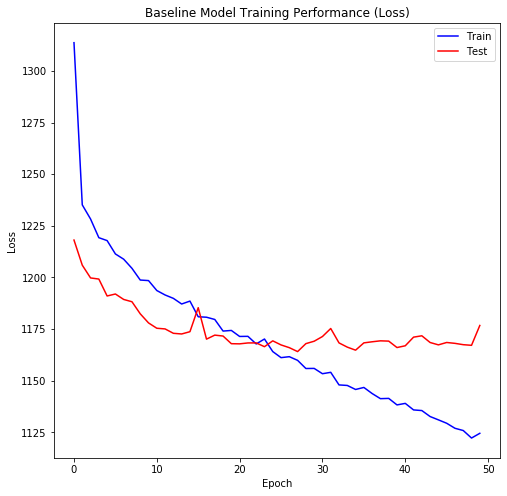

In [0]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_2_c = create_model_2_c()
baseline_hist_2_c = baseline_model_2_c.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist_2_c.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_2_c.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1332.3690 - val_loss: 1223.2477
Epoch 2/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1251.3019 - val_loss: 1210.3199
Epoch 3/50
141238/141238 [==============================] - 10s 67us/sample - loss: 1243.7021 - val_loss: 1205.5248
Epoch 4/50
141238/141238 [==============================] - 10s 67us/sample - loss: 1237.3400 - val_loss: 1201.9242
Epoch 5/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1233.4655 - val_loss: 1198.0658
Epoch 6/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1230.1694 - val_loss: 1199.6570
Epoch 7/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1228.7002 - val_loss: 1201.5660
Epoch 8/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1225.6977 - val_loss: 1198.0530
Epoch 9/50
141238/141

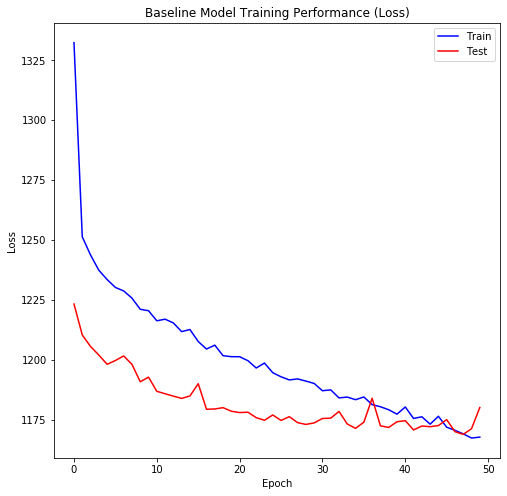

In [0]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_2_d = create_model_2_d()
baseline_hist_2_d = baseline_model_2_d.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist_2_d.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_2_d.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
if (notifyStatus): email_notify("Phase 4 Fit and Evaluate Model Set #2! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Fit and Evaluate Model Set #3

In [0]:
if (notifyStatus): email_notify("Phase 5 Fit and Evaluate Model Set #3 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Define MLP model #3_a
def create_model_3_a():
    default_model = Sequential()
    default_model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(256, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #3_b
def create_model_3_b():
    default_model = Sequential()
    default_model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(256, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #3_c
def create_model_3_c():
    default_model = Sequential()
    default_model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(256, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #3_d
def create_model_3_d():
    default_model = Sequential()
    default_model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(256, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1244.1778 - val_loss: 1206.8969
Epoch 2/50
141238/141238 [==============================] - 9s 66us/sample - loss: 1186.9491 - val_loss: 1199.1275
Epoch 3/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1176.3951 - val_loss: 1191.1557
Epoch 4/50
141238/141238 [==============================] - 9s 66us/sample - loss: 1167.3240 - val_loss: 1184.6267
Epoch 5/50
141238/141238 [==============================] - 9s 67us/sample - loss: 1159.4768 - val_loss: 1179.1524
Epoch 6/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1151.4521 - val_loss: 1176.3771
Epoch 7/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1144.8783 - val_loss: 1173.3249
Epoch 8/50
141238/141238 [==============================] - 9s 66us/sample - loss: 1139.3675 - val_loss: 1171.7854
Epoch 9/50
141238/141238 

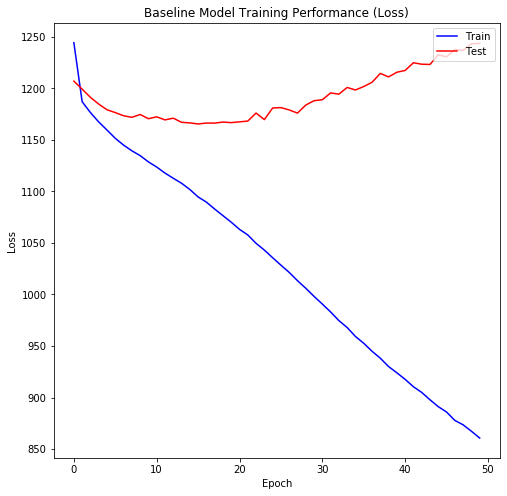

In [0]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_3_a = create_model_3_a()
baseline_hist_3_a = baseline_model_3_a.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist_3_a.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_3_a.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1257.7839 - val_loss: 1213.1540
Epoch 2/50
141238/141238 [==============================] - 10s 69us/sample - loss: 1200.9971 - val_loss: 1202.5846
Epoch 3/50
141238/141238 [==============================] - 10s 72us/sample - loss: 1192.3924 - val_loss: 1195.2142
Epoch 4/50
141238/141238 [==============================] - 10s 69us/sample - loss: 1182.8415 - val_loss: 1185.9778
Epoch 5/50
141238/141238 [==============================] - 10s 69us/sample - loss: 1176.0066 - val_loss: 1180.8926
Epoch 6/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1169.0746 - val_loss: 1176.6418
Epoch 7/50
141238/141238 [==============================] - 10s 72us/sample - loss: 1163.0176 - val_loss: 1176.4373
Epoch 8/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1157.7688 - val_loss: 1170.5028
Epoch 9/50
141238/141

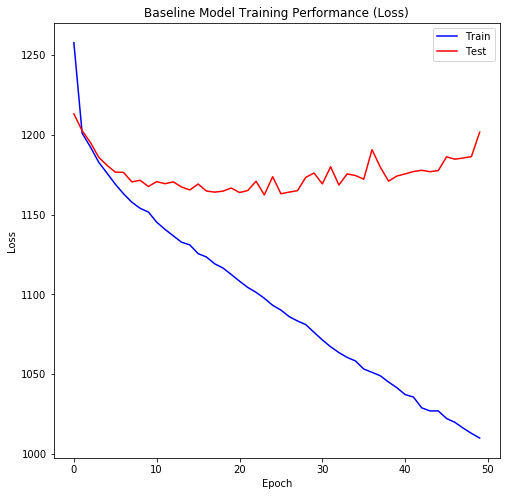

In [0]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_3_b = create_model_3_b()
baseline_hist_3_b = baseline_model_3_b.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist_3_b.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_3_b.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 10s 73us/sample - loss: 1270.4732 - val_loss: 1213.7913
Epoch 2/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1213.0240 - val_loss: 1206.7720
Epoch 3/50
141238/141238 [==============================] - 10s 69us/sample - loss: 1207.3315 - val_loss: 1195.5921
Epoch 4/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1198.2478 - val_loss: 1190.5970
Epoch 5/50
141238/141238 [==============================] - 10s 69us/sample - loss: 1192.7475 - val_loss: 1185.1422
Epoch 6/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1186.5915 - val_loss: 1182.0163
Epoch 7/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1179.0620 - val_loss: 1179.0175
Epoch 8/50
141238/141238 [==============================] - 10s 72us/sample - loss: 1175.0094 - val_loss: 1177.9293
Epoch 9/50
141238/141

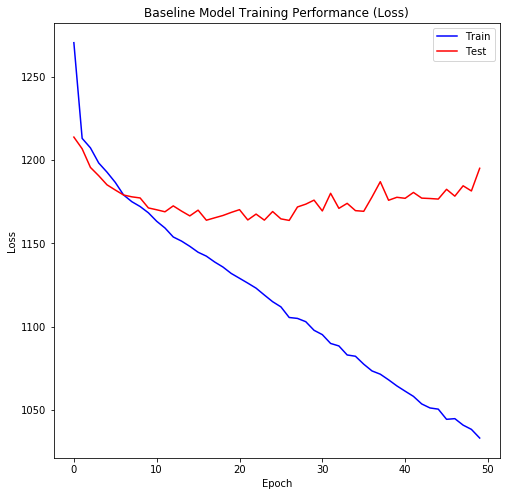

In [0]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_3_c = create_model_3_c()
baseline_hist_3_c = baseline_model_3_c.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist_3_c.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_3_c.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 10s 73us/sample - loss: 1282.1148 - val_loss: 1217.0794
Epoch 2/50
141238/141238 [==============================] - 10s 69us/sample - loss: 1223.0531 - val_loss: 1206.7677
Epoch 3/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1218.8641 - val_loss: 1202.6947
Epoch 4/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1212.3506 - val_loss: 1196.5345
Epoch 5/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1207.9849 - val_loss: 1192.5291
Epoch 6/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1202.5581 - val_loss: 1192.9753
Epoch 7/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1198.4479 - val_loss: 1197.8742
Epoch 8/50
141238/141238 [==============================] - 10s 72us/sample - loss: 1195.4814 - val_loss: 1187.1217
Epoch 9/50
141238/141

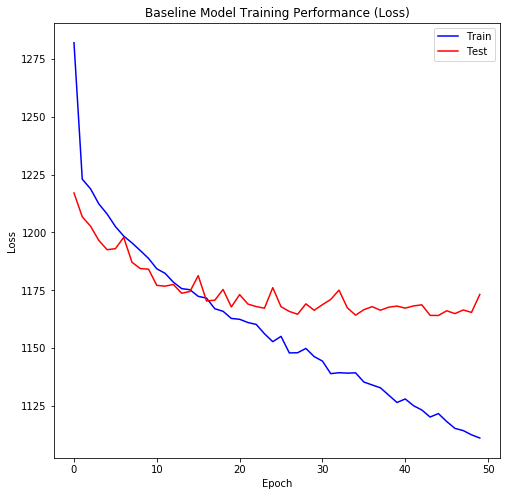

In [0]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_3_d = create_model_3_d()
baseline_hist_3_d = baseline_model_3_d.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist_3_d.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_3_d.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
# Not applicable for this iteration of the model

In [0]:
if (notifyStatus): email_notify("Phase 5 Fit and Evaluate Model Set #3 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 6. Fit and Evaluate Model Set #4

In [0]:
if (notifyStatus): email_notify("Phase 6 Fit and Evaluate Model Set #4 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Define MLP model #4_a
def create_model_4_a():
    default_model = Sequential()
    default_model.add(Dense(1024, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(512, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #4_b
def create_model_4_b():
    default_model = Sequential()
    default_model.add(Dense(1024, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(512, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #4_c
def create_model_4_c():
    default_model = Sequential()
    default_model.add(Dense(1024, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.25))
    default_model.add(Dense(512, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
# Define MLP model #4_d
def create_model_4_d():
    default_model = Sequential()
    default_model.add(Dense(1024, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(512, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 10s 69us/sample - loss: 1229.1208 - val_loss: 1201.6362
Epoch 2/50
141238/141238 [==============================] - 10s 67us/sample - loss: 1180.5271 - val_loss: 1189.4967
Epoch 3/50
141238/141238 [==============================] - 9s 67us/sample - loss: 1166.3884 - val_loss: 1186.8169
Epoch 4/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1155.3143 - val_loss: 1180.0556
Epoch 5/50
141238/141238 [==============================] - 10s 67us/sample - loss: 1146.4214 - val_loss: 1171.3034
Epoch 6/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1138.0667 - val_loss: 1166.8495
Epoch 7/50
141238/141238 [==============================] - 9s 67us/sample - loss: 1129.4043 - val_loss: 1165.7790
Epoch 8/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1122.7230 - val_loss: 1166.6734
Epoch 9/50
141238/14123

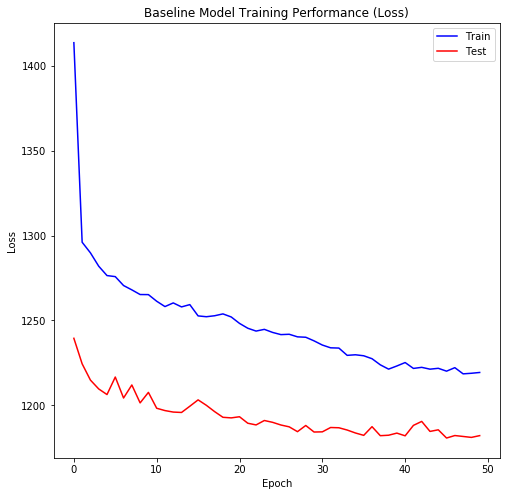

In [0]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_4_a = create_model_4_a()
baseline_hist_4_a = baseline_model_4_a.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist_1_d.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_1_d.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1237.8400 - val_loss: 1203.0664
Epoch 2/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1188.6315 - val_loss: 1190.6686
Epoch 3/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1175.6166 - val_loss: 1187.2264
Epoch 4/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1166.7012 - val_loss: 1177.5472
Epoch 5/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1160.4904 - val_loss: 1172.5770
Epoch 6/50
141238/141238 [==============================] - 10s 71us/sample - loss: 1153.8303 - val_loss: 1168.9060
Epoch 7/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1146.6682 - val_loss: 1172.0123
Epoch 8/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1142.2940 - val_loss: 1166.6251
Epoch 9/50
141238/141

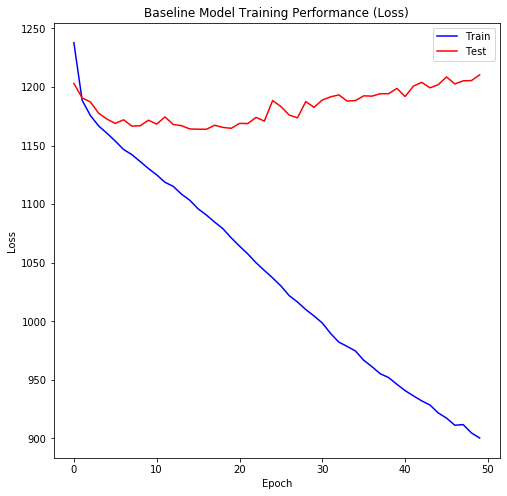

In [0]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_4_b = create_model_4_b()
baseline_hist_4_b = baseline_model_4_b.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist_4_b.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_4_b.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1244.9144 - val_loss: 1204.6834
Epoch 2/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1197.5208 - val_loss: 1192.7388
Epoch 3/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1184.5942 - val_loss: 1185.5436
Epoch 4/50
141238/141238 [==============================] - 10s 69us/sample - loss: 1174.8421 - val_loss: 1178.6157
Epoch 5/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1167.6594 - val_loss: 1173.6439
Epoch 6/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1159.9439 - val_loss: 1173.4643
Epoch 7/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1154.1177 - val_loss: 1181.9259
Epoch 8/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1151.1373 - val_loss: 1165.8566
Epoch 9/50
141238/141

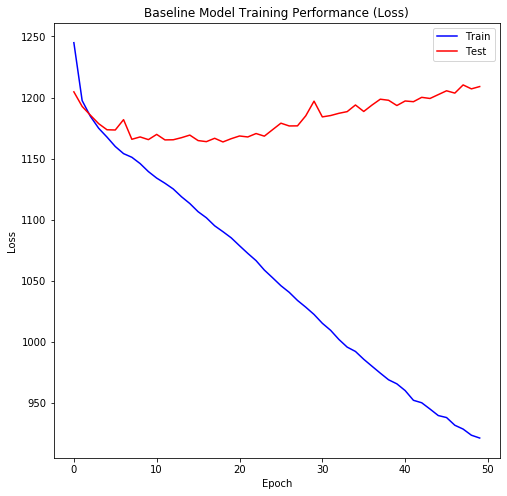

In [0]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_4_c = create_model_4_c()
baseline_hist_4_c = baseline_model_4_c.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist_4_c.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_4_c.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 10s 70us/sample - loss: 1256.0225 - val_loss: 1207.1326
Epoch 2/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1206.4740 - val_loss: 1195.8216
Epoch 3/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1195.3414 - val_loss: 1188.6926
Epoch 4/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1187.9449 - val_loss: 1181.4473
Epoch 5/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1181.5214 - val_loss: 1179.1434
Epoch 6/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1175.9273 - val_loss: 1174.6765
Epoch 7/50
141238/141238 [==============================] - 10s 68us/sample - loss: 1171.0122 - val_loss: 1174.3071
Epoch 8/50
141238/141238 [==============================] - 10s 69us/sample - loss: 1169.6310 - val_loss: 1169.9672
Epoch 9/50
141238/141

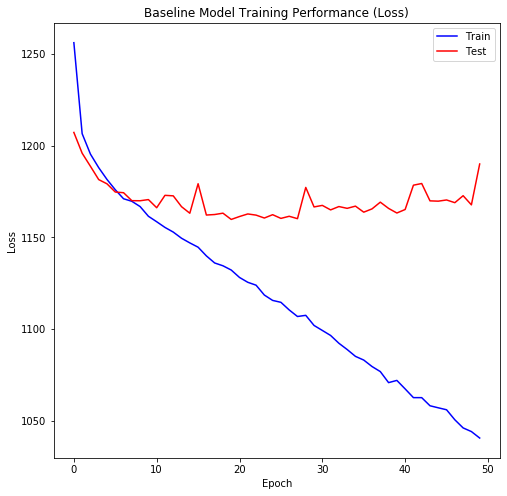

In [0]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_4_d = create_model_4_d()
baseline_hist_4_d = baseline_model_4_d.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist_4_d.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_4_d.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
if (notifyStatus): email_notify("Phase 6 Fit and Evaluate Model Set #4 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 2:11:56.293140
